In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pdb
from IPython.core.debugger import set_trace
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib

import mlflow

import cvxpy as cp
from pypfopt.expected_returns import mean_historical_return, returns_from_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier, EfficientSemivariance
from pypfopt import objective_functions
from pypfopt import plotting

idx = pd.IndexSlice

# 時間足データを保存する時に使うTimescaleDB用のユーティリティライブラリの設定
from timescaledb_util import *

pg_config = {
    'user': os.environ['POSTGRES_USER'],
    'password': os.environ['POSTGRES_PASSWORD'],
    'host': os.environ['POSTGRES_HOST'],
    'port': os.environ['POSTGRES_PORT'],
    'database': os.environ['POSTGRES_DATABASE_OHLCV_TRADES']
}

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
dbutil = TimeScaleDBUtil(user = pg_config['user'], password = pg_config['password'], host = pg_config['host'], port = pg_config['port'], database = pg_config['database'])

# mlflowの設定
mlflow.set_tracking_uri('http://mlflow:8890')
mlflow.set_experiment('crypto_portfolio_bot')

# 実験のパラメータ
experiment_options = {
    'backtest_from': '2020-01-01 00:00:00+00',
    'backtest_to': '2023-01-01 00:00:00+00',
    'efficientfrontier_type': 'EfficientMeanVariance',
    'objective_type': 'max_quadratic_utility',
    'objective_param': 1.0,
    'download_timebar': True,
    'calculate_topx': False,
    'l2_reg': True,
    'l2_reg_gamma': 0.02,
    'weight_upper_bound': 1,               # 1銘柄のポジション / 全ポジションの絶対値の合計の最大値
    'weight_lower_bound': -1,              # 1銘柄のポジション / 全ポジションの絶対値の合計の最小値
    'rebalance_interval': 24*60*60,        # ポートフォリオリバランス間隔 [秒]
    'execution_period': 18*60*60,          # ポートフォリオリバランス実行期間 [秒]
    'timebar_interval': 5*60,              # タイムバー間隔 [秒]
    'weight_calc_period': 4*7*24*60*60,    # ポートフォリオ計算時のリターン系列の長さ [秒]
    'components_swap_interval': 7*24*60*60, # ポートフォリオ銘柄入替間隔 [秒]
    'components_volume_period': 2*7*24*60*60, # ポートフォリオ銘柄入替ボリュームモニター期間 [秒]
    'execution_cost': 0.001,               # トレード手数料
    'initial_usdt_value': 10000.0          # ポートフォリオ計算開始時のUSDT残高
}

# リバランスサイクル、執行期間などの定数を5分足何本分かで計算しておく
ROWS_REBALANCE = int(experiment_options['rebalance_interval'] / experiment_options['timebar_interval'])
ROWS_EXECUTION = int(experiment_options['execution_period'] / experiment_options['timebar_interval'])
ROWS_WAIT_FOR_EXECUTION = ROWS_REBALANCE - ROWS_EXECUTION
ROWS_WEIGHT_CALC = int(experiment_options['weight_calc_period'] / experiment_options['timebar_interval'])
ROWS_COMPONENTS_SWAP_INTERVAL = int(experiment_options['components_swap_interval'] / experiment_options['timebar_interval'])
ROWS_COMPONENTS_VOLUME_PERIOD = int(experiment_options['components_volume_period'] / experiment_options['timebar_interval'])

# パラメータをmlflowのrunに記録
mlflow.end_run()
for _idx, _value in enumerate(experiment_options):
    mlflow.log_param(_value, experiment_options[_value])

In [2]:
import ccxt
from decimal import Decimal
from datetime import timezone, datetime, timedelta

# タイムバーをダウンロードしてTimescaleDBに保存する関数、所定のdict型の配列でダウンロード対象を指定する
def download_timebar(targets):
    for target in targets:
        _exchange = target['exchange']
        _ccxt_client = getattr(ccxt, _exchange)()
        _ccxt_client.load_markets()

        _symbol = target['symbol']
        _interval = target['interval']
        
        since = int(time.mktime(datetime.strptime('2019-01-01 00:00:00+0000', '%Y-%m-%d %H:%M:%S%z').timetuple()) * 1000)

        dbutil.init_timebar_table(_exchange, _symbol, _interval)
        table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)

        df = dbutil.get_latest_timebar(_exchange, _symbol, _interval)
        if type(df) != type(None):
            latest_datetime = df['datetime']
            latest_timestamp = int(latest_datetime.timestamp() * 1000) + 1

            if latest_timestamp > since:
                since = latest_timestamp

        till = int(datetime.now(tz = timezone.utc).timestamp() * 1000)
        origin = since

        with tqdm(total = int(till - origin), initial=0) as _pbar:
            _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: 0')
            while since <= till:
                time.sleep(ccxt_client.rateLimit / 1000)

                result = ccxt_client.fetch_ohlcv(_symbol, _interval, since = int(since), limit = 1000) # 5min

                df = pd.DataFrame.from_dict(result, dtype=str)
                if len(df) == 0:
                    break

                _to_decimal = lambda x: Decimal(x)

                df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
                df['datetime'] = df['datetime'].apply(lambda x: datetime.fromtimestamp(float(x) / 1000, tz = timezone.utc))
                df['datetime_from'] = df['datetime'] - timedelta(seconds=300) - timedelta(microseconds=1)
                df['open'] = df['open'].apply(_to_decimal)
                df['high'] = df['high'].apply(_to_decimal)
                df['low'] = df['low'].apply(_to_decimal)
                df['close'] = df['close'].apply(_to_decimal)
                df['volume'] = df['volume'].apply(_to_decimal)
                
                # 取引ボリュームの推定を行い記録する
                df['dollar_volume'] = df['volume'] * (df['open'] + df['close'] + df['high'] + df['low']) / Decimal(4)

                nan_columns = ['id', 'id_from', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum', 'dollar_buy_cumsum', 'dollar_sell_cumsum']
                for column in nan_columns:
                    df[column] = Decimal(0)

                ret = dbutil.df_to_sql(df=df, schema = table_name, if_exists = 'append')

                since = int(df.iloc[-1]['datetime'].timestamp()*1000) + 1
                _pbar.n = since - origin
                _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: {len(df)}')
                _pbar.refresh()
            
            _pbar.n = int(till - origin)
            _pbar.refresh()            

In [3]:
# BinanceのUSDT建ての無期限先物をターゲットとして設定する
ccxt_client = getattr(ccxt, 'binanceusdm')()
ccxt_client.load_markets()

targets = []
for symbol in ccxt_client.symbols:
    if '/USDT' in symbol:
        target_5m = {
            'exchange': 'binanceusdm',
            'symbol': symbol,
            'interval': f'{experiment_options["timebar_interval"]/60:.0f}m'
        }
        targets.append(target_5m)

if experiment_options['download_timebar'] == True:
    # USDT建ての無期限先物の5分足をTimescaleDBにダウンロードする
    download_timebar(targets)

100%|██████████| 1915848/1915848 [00:00<00:00, 5752639.26it/s, binanceusdm, ZRX/USDT, 5m, row_counts: 6] 


In [4]:
# ポートフォリオ構成銘柄の価格系列などを準備する
dfs = []
for _target in tqdm(targets):
    _symbol = _target['symbol']
    _exchange = _target['exchange']
    _interval = _target['interval']
    
    _table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)
    
    _sql = f'SELECT datetime, close, dollar_volume from "{_table_name}" WHERE datetime BETWEEN timestamp \'{experiment_options["backtest_from"]}\' - interval \'{experiment_options["weight_calc_period"]} seconds\' AND timestamp \'{experiment_options["backtest_to"]}\' ORDER BY datetime ASC'
    _df = dbutil.read_sql_query(_sql, index_column = '')
    if len(_df) > 0:
        _df.loc[:, 'symbol'] = _symbol
        _df.dropna(inplace = True)
        dfs.append(_df)
        
# df_portfolioを準備
df_portfolio = pd.concat(dfs)

# df_portfolioにUSDT/USDTを追加
_unique_datetime = df_portfolio['datetime'].unique()
_df_usdt = pd.DataFrame(index=_unique_datetime, columns= ['symbol', 'close', 'dollar_volume']).rename_axis('datetime').reset_index()
_df_usdt.loc[:, 'symbol'] = 'USDT/USDT'
_df_usdt.loc[:, 'close'] = 1.0
_df_usdt.loc[:, 'dollar_volume'] = 0
df_portfolio = pd.concat([df_portfolio, _df_usdt]).set_index(['symbol', 'datetime']).sort_index(level=['symbol', 'datetime'])

# 全銘柄がそろっている最新の時間を抽出し、df_portfolioをスライスする
_latest_datetime = df_portfolio.loc[idx['1000BTTC/USDT', :], :].index[-1][1]
df_portfolio = df_portfolio.loc[idx[:, :f'{_latest_datetime}'], :]

100%|██████████| 140/140 [02:45<00:00,  1.18s/it]


In [5]:
# ポートフォリオ計算に利用するクローズとボリューム用のデータフレームを準備
_df_close = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close')
_df_dollar_volume_sma = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='dollar_volume').apply(lambda volume: talib.SMA(volume, ROWS_COMPONENTS_VOLUME_PERIOD))

# さらにポートフォリオ計算の結果や、ポジションの価値等を保続するデータフレームを準備 (全てのデータフレームは_df_closeと同じshapeを持つ)
_df_target_weight = _df_close.copy()
_df_target_weight[:] = np.nan # ffillとbfillを使うので、np.nanで埋める必要がある
_df_real_weight = _df_close.copy()
_df_real_weight[:] = 0
_df_position = _df_close.copy()
_df_position[:] = 0
_df_usdt_value = _df_close.copy()
_df_usdt_value[:] = 0
_df_fee = _df_close.copy()
_df_fee[:] = 0

In [6]:
# PyPortfolioOptを利用して目標ポートフォリオウェイトを計算 (_df_target_weightを埋める)

# 銘柄を格納する配列
_portfolio_components = []

for i in tqdm(range(_df_close.shape[0])):
    # リバランスタイミングでない場合は処理を行わない
    _seconds = _df_close.index[i].value // 10**9
    if _seconds % experiment_options['rebalance_interval'] != 0:
        continue
    
    # 全てのウェイトを0で初期化する
    _df_target_weight.iloc[i, :] = 0
        
    # まだポートフォリオ計算に必要なclose系列の長さがない場合は、USDT 100%のウェイトを_df_target_weightに設定してウェイト計算を終了する
    if i + 1 < ROWS_WEIGHT_CALC:
        _df_target_weight.iloc[i, _df_target_weight.columns.get_loc('USDT/USDT')] = 1
        continue
    
    # 銘柄入れ替えタイミングか、銘柄配列が空の場合はポートフォリオ銘柄を再計算する
    if i % ROWS_COMPONENTS_SWAP_INTERVAL or len(_portfolio_components) == 0:
        # 取引ボリュームの順位を計算し、10位以内の銘柄名をリストとして抽出する
        _volume_rank = _df_dollar_volume_sma.iloc[i].rank(ascending = False)
        _portfolio_components = list(_volume_rank[_volume_rank <= 10].index.values)
    
    # ポートフォリオウェイト計算用のクローズ系列を抽出する
    _df_close_window = _df_close.iloc[max(0, i - ROWS_WEIGHT_CALC + 1):i + 1, :]
    _df_close_window = _df_close_window.loc[:, _portfolio_components]
    
    # ここよりPyPortfolioOptによるポートフォリオウェイト計算
    _mu = mean_historical_return(_df_close_window)
    _historical_returns = returns_from_prices(_df_close_window).fillna(0)

    if experiment_options['efficientfrontier_type'] == 'EfficientSemivariance':
        # デフォルトのECOSソルバーではエラーが出るので、SCSを使う
        _ef = EfficientSemivariance(_mu, _historical_returns, solver='SCS', weight_bounds = (experiment_options['weight_lower_bound'], experiment_options['weight_upper_bound']))
    else:
        _S = CovarianceShrinkage(_historical_returns, returns_data=True).ledoit_wolf()
        _ef = EfficientFrontier(_mu, _S, weight_bounds = (experiment_options['weight_lower_bound'], experiment_options['weight_upper_bound']))

    if experiment_options['l2_reg'] == True:
        _ef.add_objective(objective_functions.L2_reg, gamma=experiment_options['l2_reg_gamma']) # L2正則化を入れてひとつの銘柄にウェイトが集中するのを防ぐ

    # メモ : 負のポジションを許し、ポジションの絶対値の合計を1以下にするためにpyportfoliooptの_make_weight_sum_constraint関数に変更を加えている
    #def _make_weight_sum_constraint(self, is_market_neutral):
    #    ...
    #    else:
    #        # Check negative bound
    #        negative_possible = np.any(self._lower_bounds < 0)
    #        if negative_possible:
    #            # Use norm1 as position constraint
    #            self.add_constraint(lambda w: cp.sum(cp.abs(w)) <= 1)
    #        else: 
    #            self.add_constraint(lambda w: cp.sum(w) == 1)
    #    self._market_neutral = is_market_neutral

    # 目標ウェイトを計算する
    if experiment_options['objective_type'] == 'max_quadratic_utility':
        _weights = _ef.max_quadratic_utility(risk_aversion = experiment_options['objective_param'])
    elif experiment_options['objective_type'] == 'max_sharpe':
        _weights = _ef.max_sharpe()
    elif experiment_options['objective_type'] == 'min_volatility':
        if experiment_options['efficientfrontier_type'] == 'EfficientSemivariance':
            _weights = _ef.min_semivariance()
        else:
            _weights = _ef.min_volatility()
    elif experiment_options['objective_type'] == 'efficient_risk':
        if experiment_options['efficientfrontier_type'] == 'EfficientSemivariance':
            _weights = _ef.efficient_risk(target_semideviation = experiment_options['objective_param'])
        else:
            _weights = _ef.efficient_risk(target_volatility = experiment_options['objective_param'])
    elif experiment_options['objective_type'] == 'efficient_return':
        _weights = _ef.efficient_return(target_return = experiment_options['objective_param'])

    # 目標ウェイトを書き込み
    _cleaned_weights = _ef.clean_weights()
    for _key, _value in _cleaned_weights.items():
        _df_target_weight.iloc[i, _df_target_weight.columns.get_loc(_key)] = _value

    # 目標ウェイトを合計して1にならない場合があるので、補正を行う
    _target_weights = _df_target_weight.iloc[i]
    
    if np.count_nonzero(_target_weights) == 1:
        # 構成銘柄が1つしかない場合は、足りないウェイトをUSDT/USDTに足す
        _df_target_weight.iloc[i, _df_target_weight.columns.get_loc('USDT/USDT')] += (1 - _target_weights.abs().sum())
    elif _target_weights.abs().sum() > 0:
        # 構成銘柄が複数ある場合は、正規化を行う
        _df_target_weight.iloc[i, :] = _target_weights /_target_weights.abs().sum()

# リバランスタイミングの間にある行の目標ウェイトをffillで埋める
_df_target_weight.fillna(method='ffill', inplace=True)
_df_target_weight.fillna(method='bfill', inplace=True)
_df_target_weight.fillna(0, inplace=True)

100%|██████████| 240096/240096 [00:27<00:00, 8642.35it/s]


In [7]:
# 初期ウェイトと初期ポジションをセットする
_df_target_weight.iloc[0, :] = 0
_df_target_weight.iloc[0, _df_target_weight.columns.get_loc('USDT/USDT')] = 1
_df_real_weight.iloc[0, :] = 0
_df_real_weight.iloc[0, _df_real_weight.columns.get_loc('USDT/USDT')] = 1
_df_position.iloc[0, :] = 0
_df_position.iloc[0, _df_position.columns.get_loc('USDT/USDT')] = experiment_options['initial_usdt_value']
_df_usdt_value.iloc[0, :] = 0
_df_usdt_value.iloc[0, _df_usdt_value.columns.get_loc('USDT/USDT')] = experiment_options['initial_usdt_value']

In [8]:
# 5分足でのリバランス処理の計算を行う
for i in tqdm(range(1, _df_target_weight.shape[0], 1)):
    _step_in_rebalance_cycle = (_df_target_weight.index[i].value // 10**9 // experiment_options['timebar_interval']) % ROWS_REBALANCE
    
    # リバランス前のポートフォリオの現在時刻での合計価値は、直前の行のポジションを利用して計算する
    _value_before_rebalance = _df_usdt_value.iloc[i-1] + (_df_close.iloc[i] - _df_close.iloc[i-1]) * _df_position.iloc[i-1].abs()
    _value_before_rebalance.fillna(0, inplace=True)
    _value_before_rebalance_abssum = _value_before_rebalance.abs().sum()
    
    if _step_in_rebalance_cycle >= ROWS_WAIT_FOR_EXECUTION:
        # リバランスサイクルの中の執行期間に入っていたらリバランス後のウェイトを求める
        _df_real_weight.iloc[i] = _df_real_weight.iloc[i-1] + (_df_target_weight.iloc[i] - _df_real_weight.iloc[i-1]) / (ROWS_REBALANCE - _step_in_rebalance_cycle) # 1/残りリバランス回数に分割してvalueを調整していく
        
        # リバランス後のウェイトの絶対値の合計が1にならない場合があるので正規化しておく
        # ウェイトが0でない銘柄が1銘柄しかない場合は、割り算で正規化せず、不足分をUSDTに割り当てる
        _df_real_weight_abssum = _df_real_weight.iloc[i].abs().sum()
        if np.count_nonzero(_df_real_weight.iloc[i]) == 1:
            _df_real_weight.iloc[i, _df_real_weight.columns.get_loc('USDT/USDT')] += 1 - _df_real_weight_abssum
        elif _df_real_weight_abssum > 0:
            _df_real_weight.iloc[i] /= _df_real_weight_abssum            
        
        # リバランス前と後のウェイトの差を計算し、リバランス前の資産合計から手数料を引いておく
        _weight_diff_abs = (_df_real_weight.iloc[i] - _df_real_weight.iloc[i-1] ).abs()
        _df_fee.iloc[i] = _value_before_rebalance_abssum * _weight_diff_abs * experiment_options['execution_cost']
        _value_after_fee_abssum = _value_before_rebalance_abssum * (1 - _weight_diff_abs.sum() * experiment_options['execution_cost'])
        
        # 銘柄ごとのバリューを更新
        _df_usdt_value.iloc[i] = _value_after_fee_abssum * _df_real_weight.iloc[i]
        
        # ポジションを更新
        _df_position.iloc[i] = (_df_usdt_value.iloc[i] / _df_close.iloc[i]).fillna(0)
    else:
        # 直前のポジションを維持し、最新のクローズ価格でバリューを調整する
        _df_position.iloc[i] = _df_position.iloc[i-1]
        _df_usdt_value.iloc[i] = _df_usdt_value.iloc[i-1] + (_df_close.iloc[i] - _df_close.iloc[i-1]).fillna(0) * _df_position.iloc[i-1].abs()
        _df_real_weight.iloc[i] = _df_usdt_value.iloc[i] / _df_usdt_value.iloc[i].abs().sum()

100%|██████████| 240095/240095 [14:55<00:00, 268.23it/s]


In [9]:
# パフォーマンス表示用の関数
def visualize_performance(df_weight, df_position, df_value, df_fee, df_close, render_from, render_to, options):
    _fig, _ax = plt.subplots(4, 1, figsize=(12, 24))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # 行のすべてのウェイトが0またはNaNの行を削除してウェイト用のDataFrameを完成させる
    _df_weight = df_weight.loc[(df_weight.index.values.astype(np.int64) // 10**9) % options['rebalance_interval'] == 0, :]
    _df_weight = _df_weight.loc[render_from:render_to, :]
    _columns = _df_weight.loc[:, _df_weight.any()].columns.values
    _df_weight = _df_weight.loc[:, _columns]
    _df_weight_positive, _df_weight_negative = _df_weight.clip(upper=0), _df_weight.clip(lower=0)
    
    # ポートフォリオウェイトの描画
    _ax[0].set_xlim(_df_weight.index[0], _df_weight.index[-1])
    _ax[0].stackplot(_df_weight_positive.index, _df_weight_positive.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_weight_positive.columns)
    _df_weight_negative = _df_weight_negative.rename(columns=lambda x: '_' + x)
    _ax[0].stackplot(_df_weight_negative.index, _df_weight_negative.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_weight_negative.columns)
    _ax[0].grid(True)
    _ax[0].legend(bbox_to_anchor=(1, 1), ncol=3, loc='upper left')
    _ax[0].set_title(f'Portofolio weight')
    
    # コストを考慮した銘柄リターン表示用のデータフレームを準備
    _df_value = df_value.loc[(df_value.index.values.astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :].abs()
    _df_value = _df_value.loc[render_from:render_to, _columns]
    
    _ax[1].set_xlim(_df_value.index[0], _df_value.index[-1])
    _ax[1].stackplot(_df_value.index, _df_value.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_value.columns)
    _ax[1].grid(True)
    _ax[1].legend(bbox_to_anchor=(1, 1), ncol=3, loc='upper left')
    _ax[1].set_title('Portfolio value')
    
    # DD表示
    _df_value['total'] = _df_value.abs().sum(axis=1)
    _df_value['dd_val'] = _df_value['total'].cummax() - _df_value['total']
    _dd_end = _df_value['dd_val'].idxmax()
    _dd_start = _df_value['total'].cummax()[:_dd_end].idxmax()
    _ax[1].plot(_df_value[_dd_start:_dd_end].index, _df_value[_dd_start:_dd_end]['total'], color='r', scalex=False, scaley=False)
    _dd_dict = { 'start': _dd_start.strftime("%m/%d/%Y %H:%M:%S%z"), 'end': _dd_end.strftime("%m/%d/%Y %H:%M:%S%z"), 'dd_value': _df_value.loc[_dd_end, 'dd_val'], 'dd_pct': 1 - (_df_value.loc[_dd_end,'total'] / _df_value.loc[_dd_start, 'total']) }
    
    mlflow.log_metric(key="dd_value", value=_dd_dict['dd_value'])
    mlflow.log_metric(key="dd_pct", value=_dd_dict['dd_pct']*100)
    mlflow.log_metric(key="final_value", value=_df_value.loc[_df_value.index[-1], 'total'])
    
    # 手数料の総計をmlflowに記録
    _df_fee = df_fee[render_from:render_to]
    mlflow.log_metric(key="total fee", value=_df_fee.loc[_df_fee.index[-1], :].sum())
    
    # ウェイト調整の絶対値用のデータフレームを準備
    _df_target_weight_diff_abs = df_weight.loc[(df_weight.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :].diff().abs().fillna(0)
    _df_target_weight_diff_abs = _df_target_weight_diff_abs.loc[render_from:render_to, _columns]
    
    _ax[2].hist(_df_target_weight_diff_abs.sum(axis=1), bins=50, density=True)
    _ax[2].set_title('Weight rebalance amount histogram')
    
    # クローズ系列の描画
    _df_close = df_close.loc[(df_close.index.values.astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :].fillna(0)
    _df_close = _df_close.loc[render_from:render_to, _columns]
    _df_close = _df_close / _df_close.replace(0, np.nan).bfill(axis=1).iloc[0, :]
    _df_close.plot(ax=_ax[3])
    _ax[3].grid(True)
    _ax[3].set_title(f'Asset price')
    _ax[3].legend(bbox_to_anchor=(1, 1), ncol=3, loc='upper left')

    mlflow.log_figure(_fig, f'portofolio_{render_from}_to_{render_to}.png')
    
    return _fig

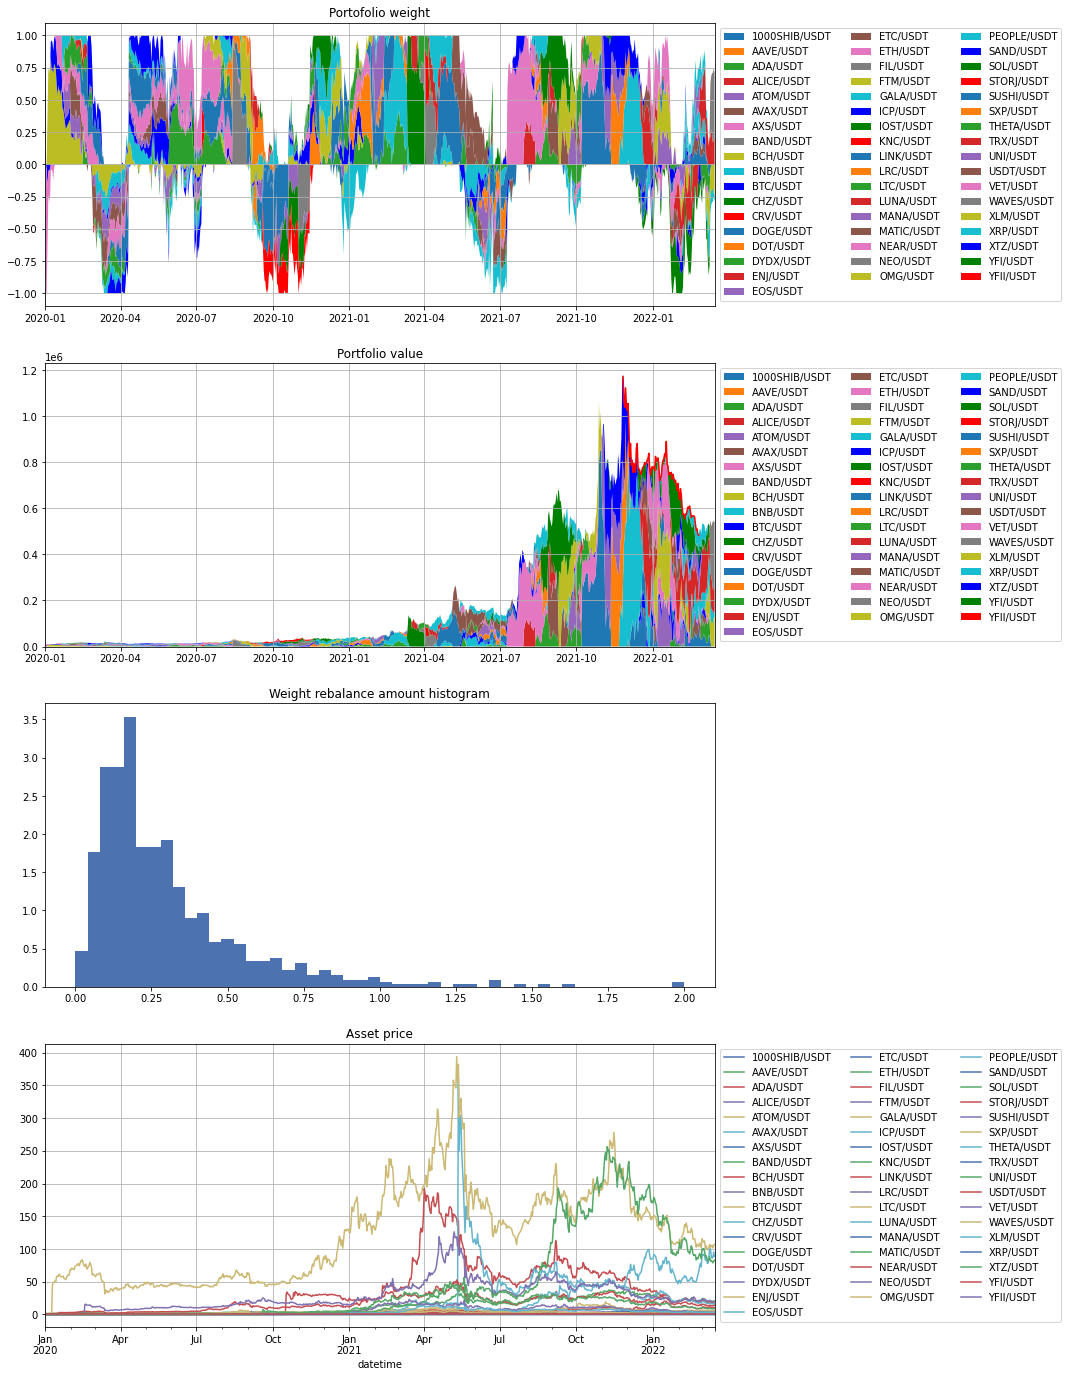

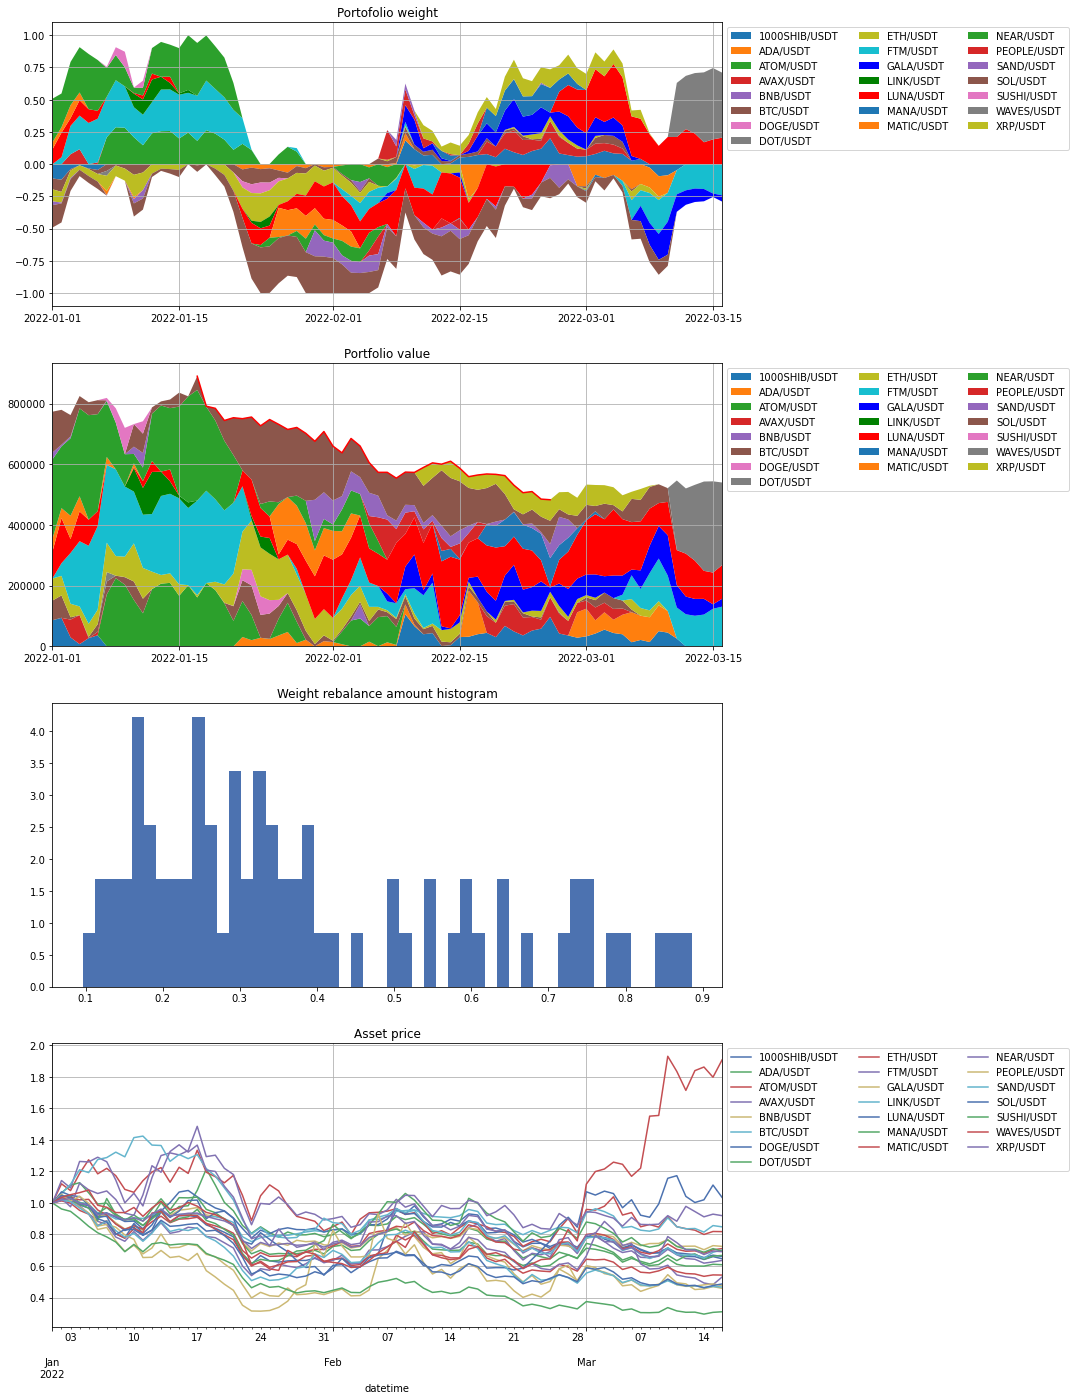

In [10]:
# パフォーマンスを表示し、ランを終了する
visualize_performance(_df_real_weight, _df_position, _df_usdt_value, _df_fee, _df_close, experiment_options['backtest_from'], experiment_options['backtest_to'], experiment_options).show()
visualize_performance(_df_real_weight, _df_position, _df_usdt_value, _df_fee, _df_close, '2022-01-01', '2023-01-01', experiment_options).show()
mlflow.end_run()